## A11535519 - Justin Laughlin
### MAE 290A: Homework 1 (10/19/17)
### Problem 4

In [1]:
# Import necessary packages & configure settings
import numpy as np
from scipy import linalg
from skimage import color
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

### Compress Monk with SVD

<img src="monk_london_1970.jpg">

In [2]:
# Read in image as array
#P = color.rgb2gray(io.imread('monk_london_1970.jpg'))
P = io.imread('monk_london_1970.jpg')

In [3]:
# number of pixels along 0 and 1 axes
n0 = 577
n1 = 800
# Initialize decomposed matrices for each channel (RGB)
U = np.ndarray([n0,n0,3], dtype=np.double)
s = np.ndarray([n0,1,3], dtype=np.double)
Vh = np.ndarray([n0,n1,3], dtype=np.double)
S = np.ndarray([n0,n0,3], dtype=np.double)

In [4]:
# Perform SVD decomposition on each RGB channel
for j in np.arange(3):
    U[:,:,j], s[:,0,j], Vh[:,:,j] = linalg.svd(P[:,:,j], full_matrices=False)
    S[:,:,j] = linalg.diagsvd(s[:,0,j],n0,n0) # construct diagonal matrix
    
    #np.allclose() returns true if the two arrays are reasonably close (to a tolerance)
    wasSVDgood = np.allclose(P[:,:,j],np.dot(U[:,:,j],np.dot(S[:,:,j],Vh[:,:,j])))
    print("SVD decomp for channel",j,"is good?",wasSVDgood)

SVD decomp for channel 0 is good? True
SVD decomp for channel 1 is good? True
SVD decomp for channel 2 is good? True


Numer of eigenvalues required to reproduce 70% of information in red channel:  30
Numer of eigenvalues required to reproduce 70% of information in green channel:  32
Numer of eigenvalues required to reproduce 70% of information in blue channel:  37


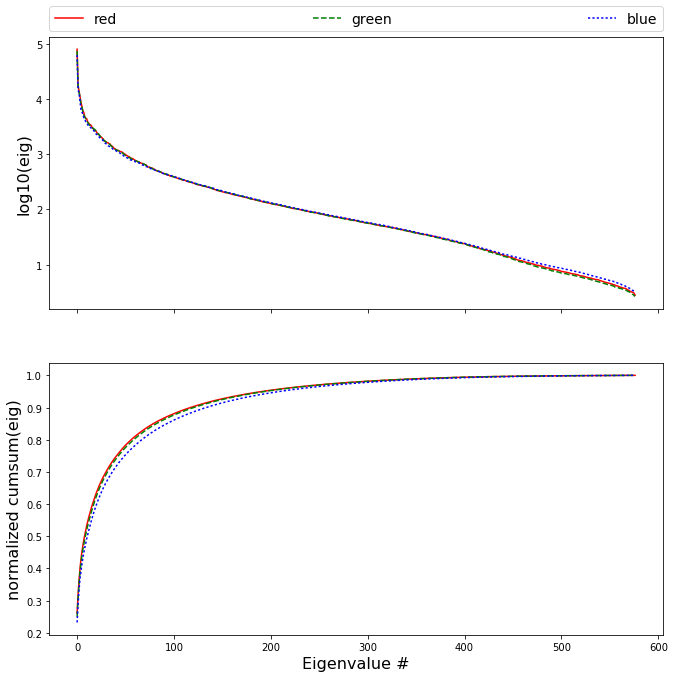

In [5]:
# Plot singular values for R, G, and B
colorvec  = ['red', 'green', 'blue']
lstylevec = ['-', '--', ':']

fig, ax = plt.subplots(2,1, figsize=(11,11), sharex='col')
for j in np.arange(3):
    logeigen = np.log10(s[:,0,j])
    sumeigen = np.cumsum(s[:,0,j]) / np.sum(s[:,0,j])
    print("Numer of eigenvalues required to reproduce 70% of information in",
          colorvec[j],"channel: ",np.argmax(sumeigen>0.7))
    
    ax[0].plot(np.arange(577), logeigen, color=colorvec[j], linestyle = lstylevec[j], label=colorvec[j])
    ax[1].plot(np.arange(577), sumeigen, color=colorvec[j], linestyle = lstylevec[j],  label=colorvec[j])
plt.xlabel('Eigenvalue #', fontsize=16)
ax[0].set_ylabel('log10(eig)', fontsize=16)
ax[1].set_ylabel('normalized cumsum(eig)', fontsize=16)

ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=14)

In [6]:
U.shape, S.shape, Vh.shape

((577, 577, 3), (577, 577, 3), (577, 800, 3))

In [7]:
kvec = [3, 10, 30, 200]
# Initialize a list of 3d numpy arrays. Icomp[0] will be the RGB matrices for k=3, Icomp[1] for k=10, etc.
Icomp = [np.ndarray([n0,n1,3], dtype=np.uint8) for i in range(len(kvec))]
for i in range(len(kvec)):
    k = kvec[i]
    for j in np.arange(3):
        Icomp[i][:,:,j] = np.dot(U[:,0:k,j], np.dot(S[0:k,0:k,j], Vh[0:k,:,j]))

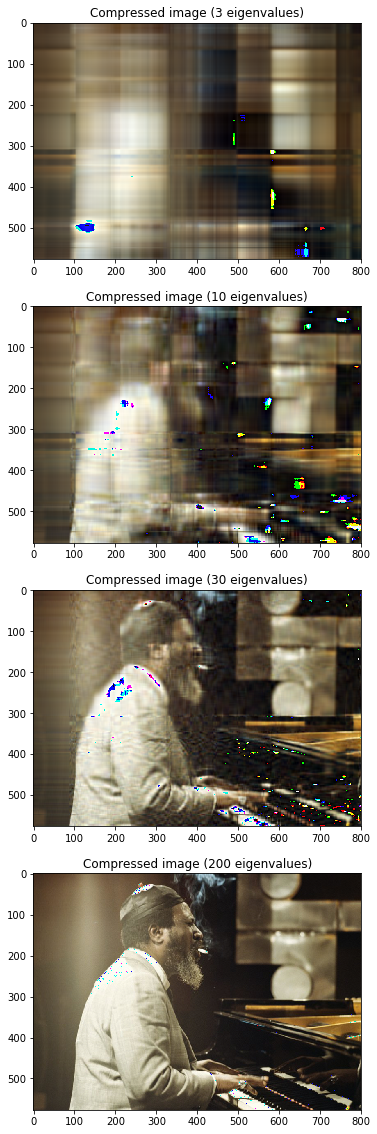

In [8]:
from matplotlib.pyplot import imshow
#from PIL import Image

fig, ax = plt.subplots(len(kvec),1, figsize=(20,20))
for j in range(len(kvec)):
    ax[j].imshow(np.asarray(Icomp[j]))
    ax[j].set_title('Compressed image (%d eigenvalues)' % kvec[j])

The original picture is a $\left[577 \times 800 \times 3\right]$ array of $\texttt{uint8}$s. Each $\texttt{uint8}$ takes up 1 byte so the total number of bytes used by the original picture is $1,384,800$.

In an SVD decomposition the number of $\texttt{doubles}$ stored is $ \left(n_0 + n_1 + 1\right) \times k$ where $n_0$ and $n_1$ are the number of pixels in the $0$ and $1$ dimensions, respectively. $k$ is the number of eigenvalues kept post-decomposition. The $+1$ is because we must store the eigenvalues as well. However, since a $\texttt{double}$ uses 8 bytes instead of 1, the number of bytes stored is $\left(n_0 + n_1 + 1\right) \times 8k$. For $n_0=577$, $n_1=800$, and $k=\left[3,10,30\right]$ we use $33,072$, $110,240$, and $330,720$ bytes, respectively. For fun a "compressed" image with 200 eigenvalues was plotted; although it does have less numbers stored than the original image, each of these numbers are of $\texttt{double}$ precision rather than $\texttt{uint8}$ thus invalidating any perceived savings in space.

One could use single precision floats (in python, $\texttt{np.float32}$) to use half as many bytes ($4$ instead of $8$); doing so could allow one to potentially get a clearer image with the same amount of bytes by using more eigenvalues. Let's try and see!

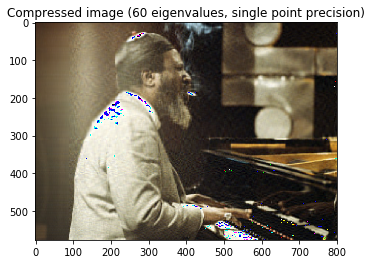

In [12]:
# SVD arrays will be single precision this time...
U32 = np.ndarray([n0,n0,3], dtype=np.float32)
s32 = np.ndarray([n0,1,3], dtype=np.float32)
Vh32 = np.ndarray([n0,n1,3], dtype=np.float32)
S32 = np.ndarray([n0,n0,3], dtype=np.float32)
Icomp32 = np.ndarray([n0,n1,3], dtype=np.uint8)
k = 60 # since we are using half as many bytes lets double the number of eigenvalues
for j in np.arange(3):
    U32[:,:,j], s32[:,0,j], Vh32[:,:,j] = linalg.svd(P[:,:,j], full_matrices=False)
    S32[:,:,j] = linalg.diagsvd(s32[:,0,j],n0,n0) # construct diagonal matrix
    Icomp32[:,:,j] = np.dot(U32[:,0:k,j], np.dot(S32[0:k,0:k,j], Vh32[0:k,:,j]))
imshow(np.asarray(Icomp32))
plt.title('Compressed image (60 eigenvalues, single point precision)')

Wow! Compare this with the image above using only 30 eigenvalues. We have used the same amount of bytes by using $\texttt{single}$ precision rather than $\texttt{double}$ and in turn, doubling the number of eigenvalues used. The image is much clearer!

Now lets compute the Fr$\ddot{o}$benius norm of $Icomp$ obtained by keeping $k$ eigenvalues as a function of $k$. We should see that as $k$ gets larger the norm should approach the norm of the original image, $P$. Visually, we can see why this would be true as the compressed image becomes more similar to the original as we keep more eigenvalues...

In [13]:
Pnorm = linalg.norm(P) # norm of the original image
Icomp_temp = np.ndarray([n0,n1,3], dtype=np.uint8)
Icomp_norm = np.zeros((n0,1))
for k in np.arange(1,n0+1):
    for j in np.arange(3):
        Icomp_temp[:,:,j] = np.dot(U[:,0:k,j], np.dot(S[0:k,0:k,j], Vh[0:k,:,j])) # construct compressed image
    Icomp_norm[k-1] = linalg.norm(Icomp_temp) # calculate frobenius norm of compressed image with k eigenvalues

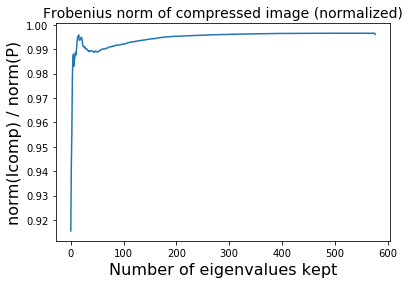

In [14]:
# Plot results
plt.plot(np.arange(n0),Icomp_norm/Pnorm)
plt.xlabel('Number of eigenvalues kept', fontsize=16)
plt.ylabel('norm(Icomp) / norm(P)',fontsize=16)
plt.title('Frobenius norm of compressed image (normalized)',fontsize=14)

As expected, the frobenius norm of the compressed image approaches that of the orginal image as the number of eigenvalues kept grows. Note that this is just one possible metric that could be used to compare two images. The frobenius norm is not unique to a single image but it is a simple and easy value to calculate. Perhaps a better way to compare the two image would be to take the norm of differences between each individual pixel; in this case we would expect this value to approach $0$ as the number of eigenvalues kept increases.